# Project: Identify Customer Segments

#### By Aly Kanyok, June 2022

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.shape

(891221, 85)

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

---

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CJT_GESAMTTYP,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
feat_info.shape

(85, 4)

In [11]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
# Transform the string-formatted column into a list
# Trim off the leading and ending square brackets and separate by commas
#feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].split(',')[1:-1]

bob = feat_info['missing_or_unknown']

In [13]:
feat_info['missing_or_unknown'] = bob.str.strip('[').str.strip(']').str.split(',')

In [14]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [15]:
# The column is now a list that we can parse to mark things as NaN
type(feat_info['missing_or_unknown'][0])

list

In [16]:
for attribute, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing[0] != '': # As long as some attribute is actually missing...
        if missing[0].isnumeric(): # Make sure it's a numeric and not alpha or special char
            missing[0] = int(missing[0])
            azdias.loc[azdias[attribute] == missing[0], attribute] = np.nan

In [17]:
# Checking a good sample to ensure NaN was applied across all multiple columns
azdias.head(15)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [18]:
# Backing up in case I corrupt it
azdias_backup = azdias.copy()

__References:__

https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/

https://www.w3schools.com/python/ref_func_zip.asp It's been a while since I used this function

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing = azdias.isnull().sum()

In [20]:
missing

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

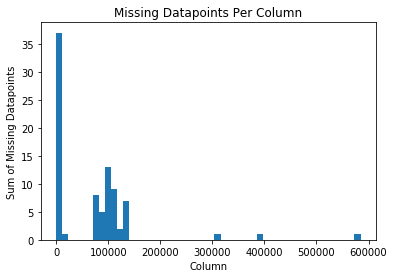

In [21]:
plt.hist(missing, bins = 50)
plt.title('Missing Datapoints Per Column')
plt.xlabel('Column')
plt.ylabel('Sum of Missing Datapoints')
plt.show()

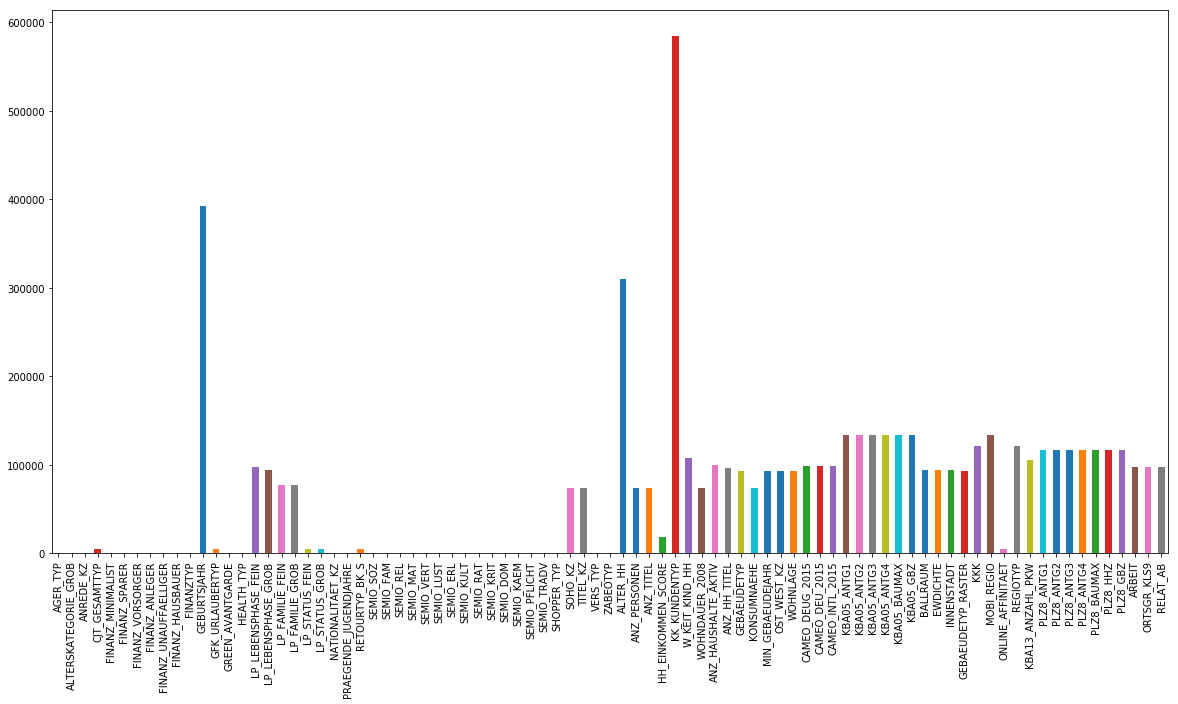

In [22]:
# Histogram shows that the majority of the columns have no NaNs, which is great!
missing.plot.bar(figsize=(20,10));

In [23]:
# Investigate patterns in the amount of missing data in each column.
## I suspect the data in the azdias table came from multiple sources, and at least one source was mising values like AGER_TYP
## Though it's weird that birthyear would have so many nulls
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_clean = azdias.drop(['GEBURTSJAHR','ALTER_HH','KK_KUNDENTYP'], axis=1)

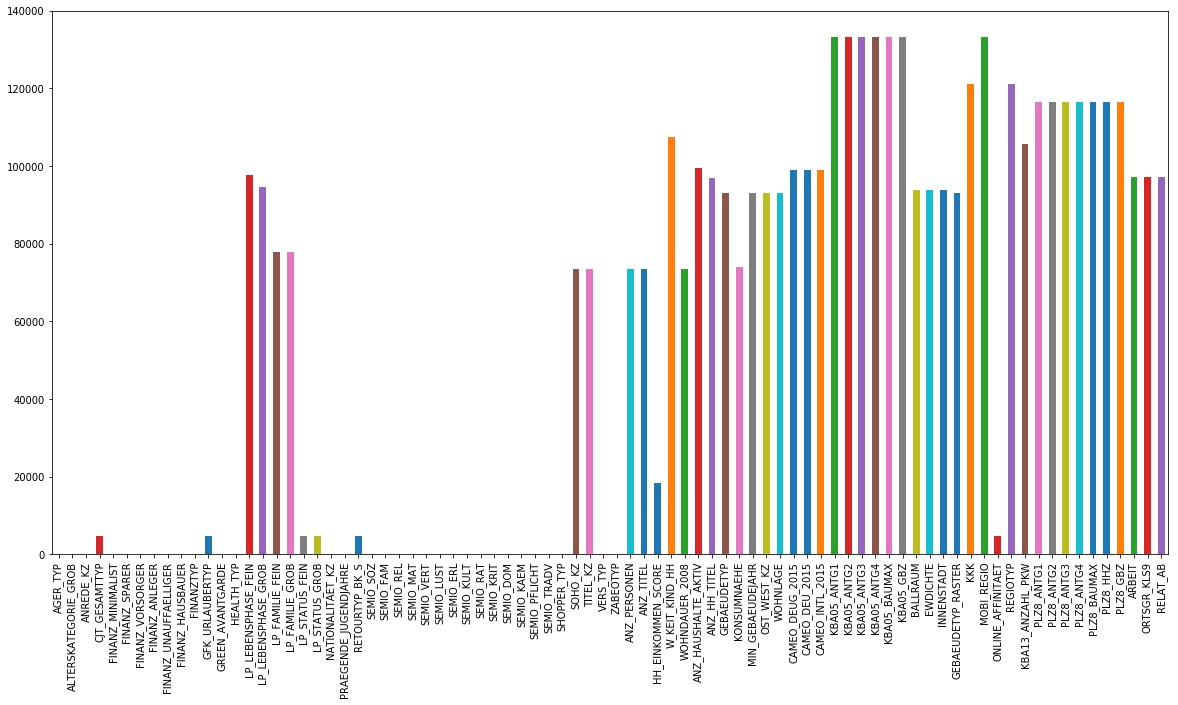

In [24]:
missing = azdias_clean.isnull().sum()
missing.plot.bar(figsize=(20,10));

In [25]:
# Calculate percentage of values in remaining columns that are NaNs
missing_perc = missing[missing > 0] / (azdias.shape[0]) * 100

In [26]:
missing_perc

CJT_GESAMTTYP           0.544646
GFK_URLAUBERTYP         0.544646
LP_LEBENSPHASE_FEIN    10.954859
LP_LEBENSPHASE_GROB    10.611509
LP_FAMILIE_FEIN         8.728699
LP_FAMILIE_GROB         8.728699
LP_STATUS_FEIN          0.544646
LP_STATUS_GROB          0.544646
RETOURTYP_BK_S          0.544646
SOHO_KZ                 8.247000
TITEL_KZ                8.247000
ANZ_PERSONEN            8.247000
ANZ_TITEL               8.247000
HH_EINKOMMEN_SCORE      2.058749
W_KEIT_KIND_HH         12.073549
WOHNDAUER_2008          8.247000
ANZ_HAUSHALTE_AKTIV    11.176913
ANZ_HH_TITEL           10.884842
GEBAEUDETYP            10.451729
KONSUMNAEHE             8.299737
MIN_GEBAEUDEJAHR       10.451729
OST_WEST_KZ            10.451729
WOHNLAGE               10.451729
CAMEO_DEUG_2015        11.106000
CAMEO_DEU_2015         11.106000
CAMEO_INTL_2015        11.106000
KBA05_ANTG1            14.959701
KBA05_ANTG2            14.959701
KBA05_ANTG3            14.959701
KBA05_ANTG4            14.959701
KBA05_BAUM

In [27]:
# None of the remaining columns have over 15% missing values, which seems reasonable compared to dropped columns

#### Discussion 1.1.2: Assess Missing Data in Each Column

We removed three key outlier columns that had large amounts of NaN entries: GEBURTSJAHR, ALTER_HH, and KK_KUNDENTYP. As noted above, it seems a little weird that the first column, birthyear, would be NaN.

Of the remaining columns, they seem to come in sets - there are a group that have around the same percentage of missing values (the KBA set, around 14.959%). Another set (the PLZ8s) around 13.07%. It seems that in some cases, multiple datasets may have been merged together. For example, if one branch office was collecting all of the data except the KBAs, when their data was merged with their fellow offices it would result in null values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
## Setting this up as a percentage per row
azdias_clean['perc_na'] = azdias_clean.isna().sum(axis=1) # Switching to 1 for rows

In [29]:
# Quick look at the new columns
azdias_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,perc_na
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
1,-1,1,2,5.0,1,5,2,5,4,5,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,5
4,-1,3,1,5.0,4,3,4,1,3,2,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


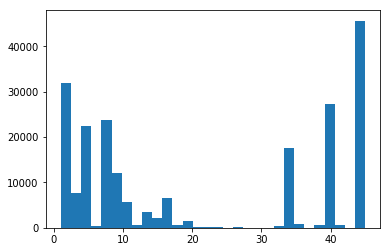

In [30]:
plt.hist(azdias_clean[azdias_clean['perc_na'] > 0]['perc_na'], bins = 30);

Percentage of 30 looks like a good middle point - not many rows around the 30 mark, though some around 27 and 32 or so

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_low = azdias_clean[azdias_clean['perc_na'] < 30]
missing_high = azdias_clean[azdias_clean['perc_na'] >= 30]

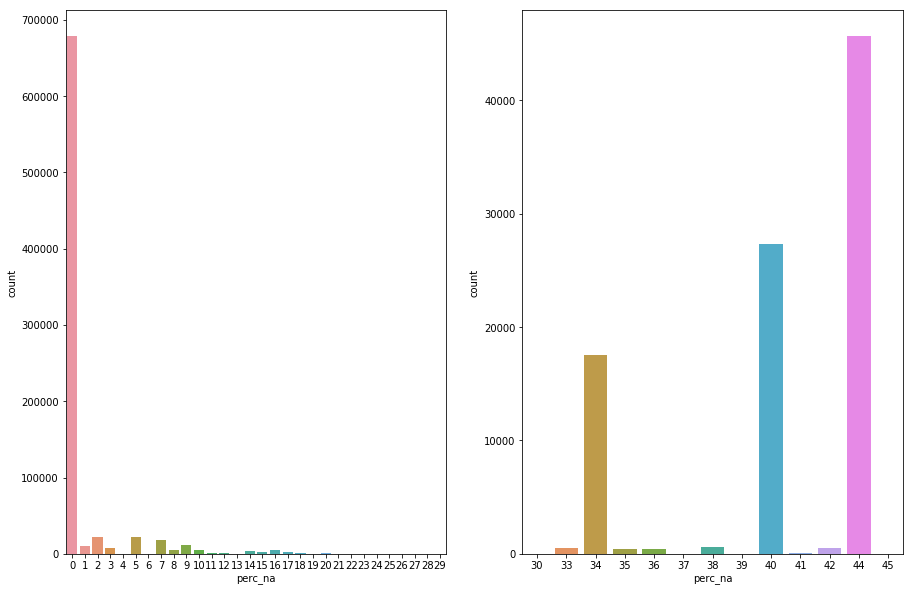

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
sns.set_palette(sns.color_palette("Paired"))
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
sns.countplot(x='perc_na', data=missing_low, ax=ax1);
sns.countplot(x='perc_na', data=missing_high, ax=ax2);

In [33]:
# Now to chart 5 columns, lows vs. highs
cols_to_chart = ('CJT_GESAMTTYP','HH_EINKOMMEN_SCORE','LP_STATUS_GROB','ONLINE_AFFINITAET','RETOURTYP_BK_S')

In [34]:
def chart_cols(col):
    fig = plt.figure(10, figsize=(20,10))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('High Count Missing Values')
    sns.countplot(missing_high[col])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Low Count Missing Values')
    sns.countplot(missing_low[col])
    
    plt.show()

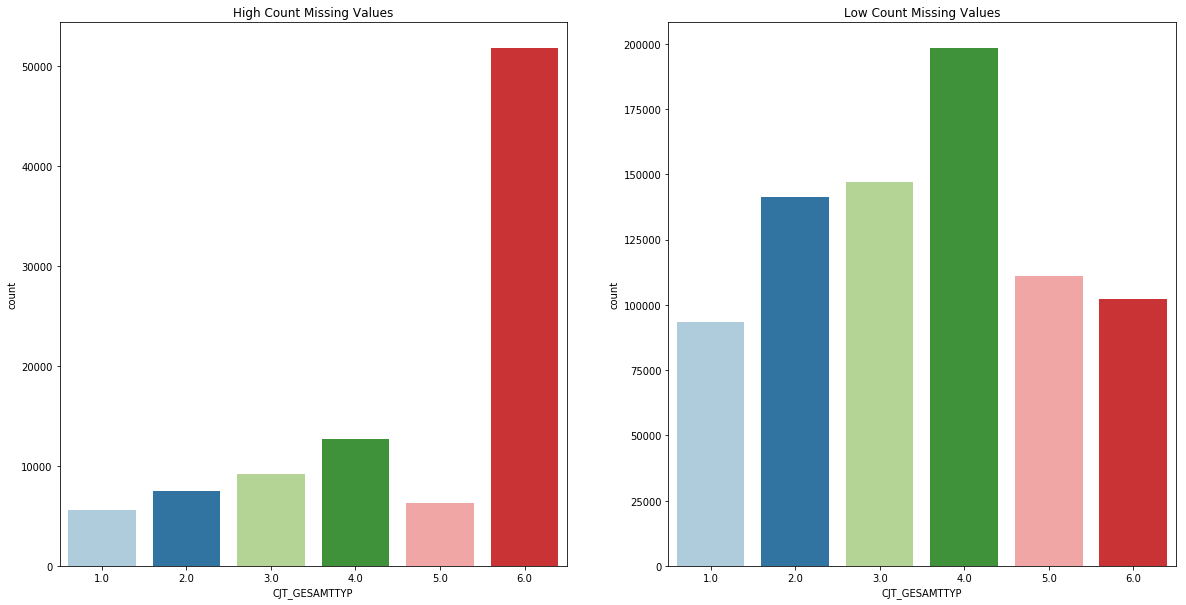

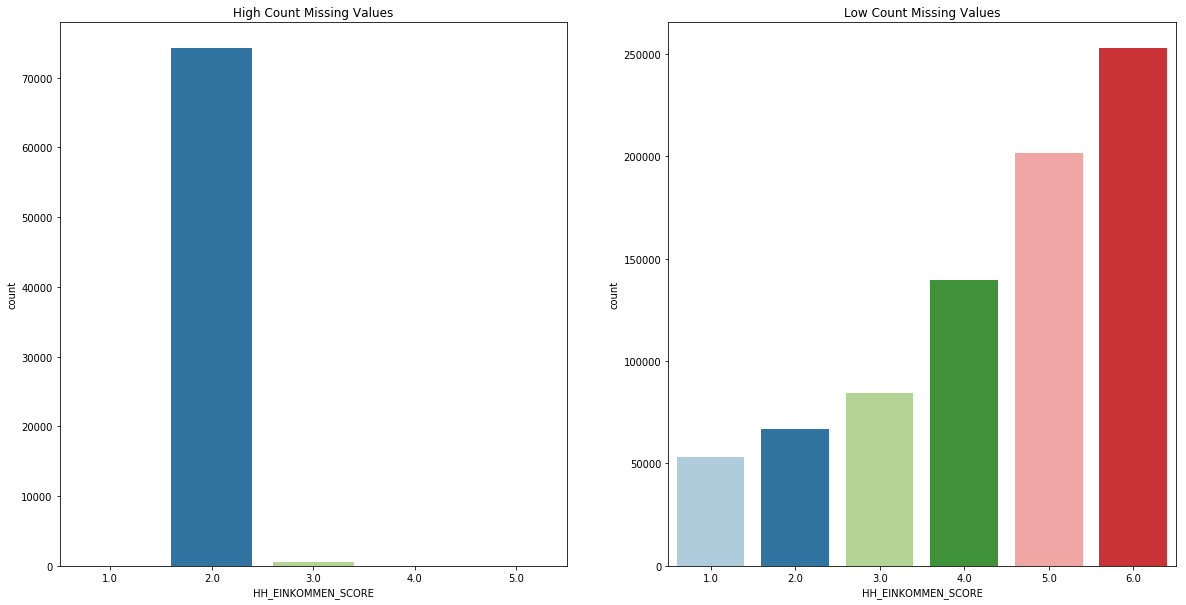

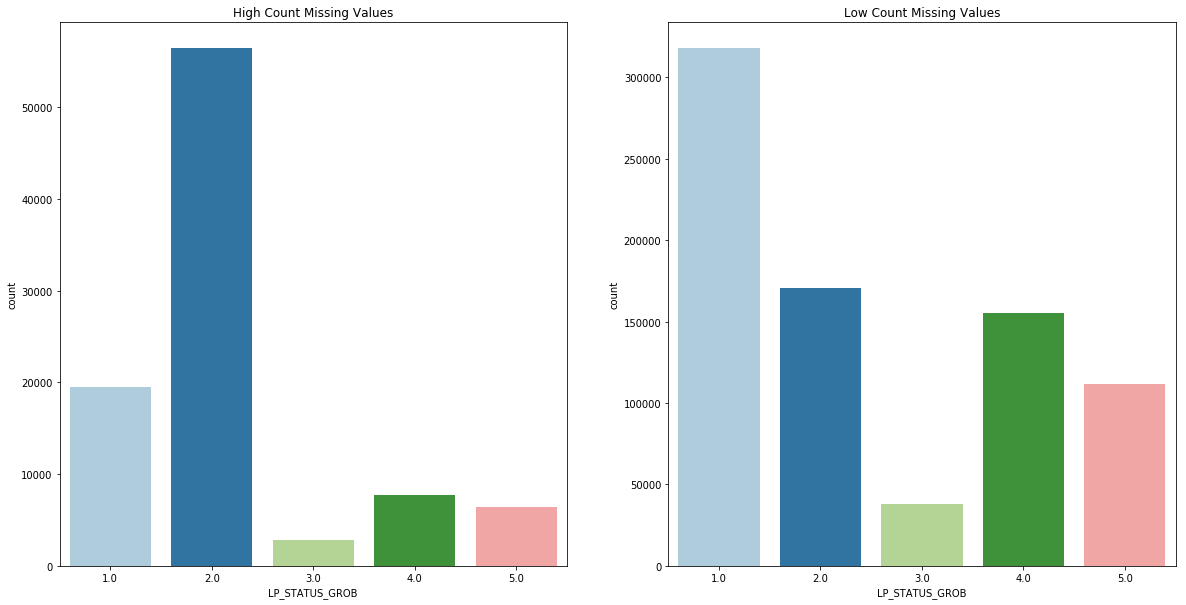

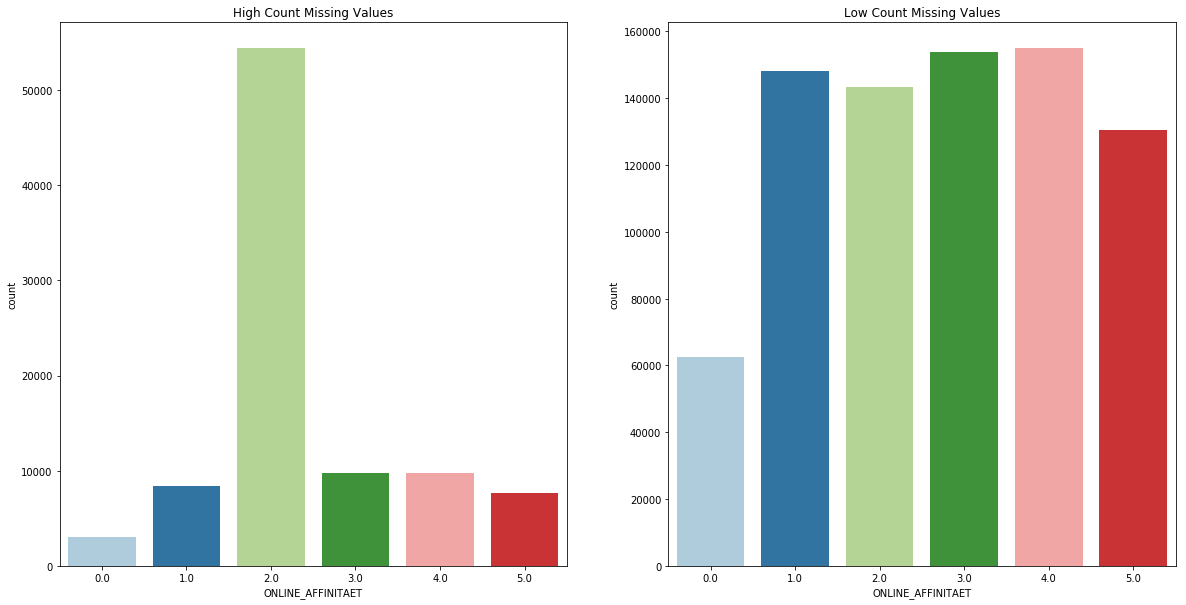

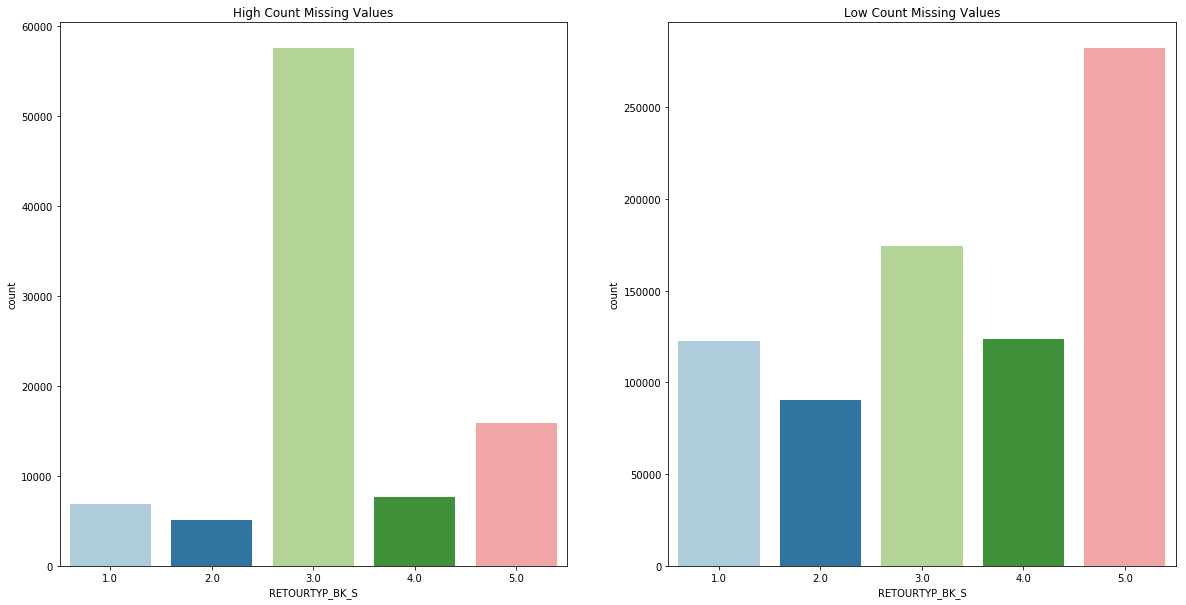

In [35]:
for i in cols_to_chart:
    chart_cols(i)

__References:__

https://seaborn.pydata.org/generated/seaborn.set_theme.html?highlight=set_theme#seaborn.set_theme

Couldn't figure out why "set_theme" per seaborn's help file wasn't working: https://github.com/mwaskom/seaborn/issues/2301

That solved the error, but no visual change.

Also tried this one: https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146

Still no visual change. So I'll stick with bright pastels for now, that's fine.

Read up more on subplots here: https://www.kaggle.com/code/asimislam/tutorial-python-subplots/notebook

#### Discussion 1.1.3: Assess Missing Data in Each Row

We split our data into two sets - one of low missing data points (where percent of row missing is less than 30%), and one of high (over 30%). When charting the data, we can see that when a specific column is missing a lot of values, it shows up very heavy in the high chart, and more evenly spread across the low count.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In the feat_info table, most of the data is either ordinal or categorical, both qualitative data types.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
# We need to drop the same columns from the feature dataframe that we did from azdias
feat_clean = feat_info.drop(feat_info.index[(feat_info["attribute"]=="KK_KUNDENTYP")],axis=0)
feat_clean = feat_clean.drop(feat_clean.index[(feat_clean["attribute"]=="GEBURTSJAHR")],axis=0)
feat_clean = feat_clean.drop(feat_clean.index[(feat_clean["attribute"]=="ALTER_HH")],axis=0)

In [38]:
## Show list of all categorical labels
cats = feat_clean[feat_clean.type == 'categorical'].attribute
cats

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [39]:
## Determine which categorical labels have more than two possible values
cat_bi = []
cat_mult = []

for col in cats:
    try:
        if azdias[col].nunique() > 2:
            cat_mult.append(col)
        else:
            cat_bi.append(col)
    except:
        break

In [40]:
for col in cat_bi:
    try:
        print(azdias_clean[col].value_counts())
    except:
        break

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [41]:
azdias_clean['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)

In [42]:
for col in cat_mult:
    try:
        print(azdias_clean[col].value_counts())       
    except:
        break

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STAT

In [43]:
cat_mult

['AGER_TYP',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_clean = pd.get_dummies(azdias_clean, columns=cat_mult)

In [45]:
# Checking on the final result
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,2,1,3,4,3,5,5,3,0,-1,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,5,2,5,4,5,0,3,...,1,0,0,0,0,0,0,0,0,0
2,3,2,1,4,1,2,3,5,1,3,...,0,0,0,0,0,0,0,0,0,0
3,4,2,4,2,5,2,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4,3,1,4,3,4,1,3,2,0,3,...,0,0,0,0,0,0,0,0,0,0


__References:__ https://www.geeksforgeeks.org/python-pandas-get_dummies-method/

#### Discussion 1.2.1: Re-Encode Categorical Features
In this section, we identified which columns were categorical, and how many values (2 or 2+) each of these columns had. For the ones with only two values (the binaries) it was an easy 1:1 switch out. For the multiple values, I used the get_dummies function from pandas, after reading a bit more about it. I didn't drop any additional columns here, because it looks like it worked out okay!

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

Snip from markdown file:
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [47]:
# I debated using a regexp here, but I really do NOT like working with regexp
# I do, however, use if/else and case statements all the time, so I will stick with those
dec = []
move = []
for i in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    # clean up decade
    if i in [1,2]:
        dec.append(40)
    elif i in [3,4]:
        dec.append(50)
    elif i in [5,6,7]:
        dec.append(60)
    elif i in [8,9]:
        dec.append(70)
    elif i in [10,11,12,13]:
        dec.append(80)
    elif i in [14,15]:
        dec.append(90)
    else:
        dec.append(0)
    # clean up movement
    if i in [1,3,5,8,10,12,14]: # mainstream
        move.append(0)
    elif i in [2,4,6,7,9,11,13,15]:  # avantgarde
        move.append(1)
    else: # I added this as an afterthought - I wanted to keep these values to just 2, so I will set "unknowns" to mainstream
        move.append(0)

In [48]:
azdias_clean['decade'] = pd.Series(dec)

In [49]:
azdias_clean['movement'] = pd.Series(move)

In [50]:
# Peek at the final results
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,movement
0,2,1,3,4,3,5,5,3,0,-1,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,5,2,5,4,5,0,3,...,0,0,0,0,0,0,0,0,90,0
2,3,2,1,4,1,2,3,5,1,3,...,0,0,0,0,0,0,0,0,90,1
3,4,2,4,2,5,2,1,2,0,2,...,0,0,0,0,0,0,0,0,70,0
4,3,1,4,3,4,1,3,2,0,3,...,0,0,0,0,0,0,0,0,70,0


__Reference:__ I didn't know what "avantgarde" meant: https://www.dictionary.com/browse/avant-garde

---

In [51]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

Snip from markdown file:

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [52]:
# On first run of my loops below, everything returned as a NaN
# So I checked the data type and it was a float - good!
# Then I added try/except - still NaNs
# Then I added the i = int(i) - bingo!
type(azdias_clean['CAMEO_INTL_2015'][0])

float

In [53]:
# Hello again, my good friend if/else!
household_type = []
family_type = []
for i in azdias_clean['CAMEO_INTL_2015']:
    # clean up household type
    try:
        i = int(i)
        if (i > 10) and (i < 20): # wealthy peeps
            household_type.append(5) # makes sense if they're a higher number, as they have more $
        elif (i > 20) and (i < 30): # prosperous
            household_type.append(4)
        elif (i > 30) and (i < 40): # comfortable
            household_type.append(3)
        elif (i > 40) and (i < 50): # less affluent
            household_type.append(2)
        elif (i > 50) and (i < 60): # poorer
            household_type.append(1)
        else:
            household_type.append(np.nan)
    except:
        household_type.append(np.nan)
    # clean up family type
    try:
        i = int(i)
        if i in [11,21,31,41,51]: #couples and singles; couples and singles ARE their own families, not "pre-family" tyvm
            family_type.append(1) # 1 for singles, yeah? 
        elif i in [12,22,32,42,52]: # young couples with kid(s)
            family_type.append(2)
        elif i in [13,23,33,43,53]: # couples with school-age kids
            family_type.append(3)
        elif i in [14,24,34,44,54]: # older families, empty nesters, etc.
            family_type.append(4)
        elif i in [15,25,35,45,55]: # retired folks
            family_type.append(5)
        else:
            family_type.append(np.nan)
    except:
        family_type.append(np.nan)

In [54]:
azdias_clean['household_type'] = pd.Series(household_type)

In [55]:
azdias_clean['family_type'] = pd.Series(family_type)

In [56]:
# Checking the results
azdias_clean.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,movement,household_type,family_type
0,2,1,3,4,3,5,5,3,0,-1,...,0,0,0,0,0,0,0,0,NaN,NaN
1,1,2,1,5,2,5,4,5,0,3,...,0,0,0,0,0,0,90,0,1.0,1.0
2,3,2,1,4,1,2,3,5,1,3,...,0,0,0,0,0,0,90,1,4.0,4.0
3,4,2,4,2,5,2,1,2,0,2,...,0,0,0,0,0,0,70,0,5.0,2.0
4,3,1,4,3,4,1,3,2,0,3,...,0,0,0,0,0,0,70,0,2.0,3.0
5,1,2,3,1,5,2,2,5,0,3,...,0,0,0,0,0,0,50,0,1.0,4.0
6,2,2,1,5,1,5,4,3,0,2,...,0,0,0,0,0,0,80,0,4.0,2.0
7,1,1,3,3,4,1,3,2,0,1,...,0,0,0,0,0,0,70,0,5.0,4.0
8,3,1,4,4,2,4,2,2,1,3,...,0,0,0,0,0,0,80,1,5.0,3.0
9,3,2,2,4,2,3,5,4,1,2,...,0,0,0,0,0,0,90,1,5.0,5.0


In [57]:
# Dropping the split columns to keep things tidy
azdias_clean.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

__Reference:__ While I've dropped plenty of columns before, there's something about this syntax that always gets me, so I always have to try several versions. And/or Google for help.

https://www.activestate.com/resources/quick-reads/how-to-delete-a-column-row-from-a-dataframe/

#### Discussion 1.2.2: Engineer Mixed-Type Features
I split two columns, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, into 4 total columns. PRAEGENDE_JUGENDJAHRE was split into decade and movement the person was born into. CAMEO_INTL_2015 was split into household type and family type. Then I dropped the original columns for tidiness.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
## I dropped the two split columns in the last step, just taking a look at the remaining column names now
azdias_clean.columns.values.tolist()

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #bob = feat_info['missing_or_unknown']
    #feat_info['missing_or_unknown'] = bob.str.strip('[').str.strip(']').str.split(',')
    for attribute, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing[0] != '': # As long as some attribute is actually missing...
            #if missing[0].isnumeric(): # Make sure it's a numeric and not alpha or special char
            try:
                missing[0] = int(missing[0])
                azdias.loc[azdias[attribute] == missing[0], attribute] = np.nan
            except:
                break
    
    # remove selected columns and rows, ...
    df_clean = df.drop(['GEBURTSJAHR','ALTER_HH','KK_KUNDENTYP'], axis=1)
    
    # select, re-encode, and engineer column values.
    df_clean = pd.get_dummies(df_clean, columns=cat_mult)

    dec = []
    move = []
    for i in df_clean['PRAEGENDE_JUGENDJAHRE']:
        # clean up decade
        if i in [1,2]:
            dec.append(40)
        elif i in [3,4]:
            dec.append(50)
        elif i in [5,6,7]:
            dec.append(60)
        elif i in [8,9]:
            dec.append(70)
        elif i in [10,11,12,13]:
            dec.append(80)
        elif i in [14,15]:
            dec.append(90)
        else:
            dec.append(0)
    
        # clean up movement
        if i in [1,3,5,8,10,12,14]: # mainstream
            move.append(0)
        elif i in [2,4,6,7,9,11,13,15]:  # avantgarde
            move.append(1)
        else: # I added this as an afterthought - I wanted to keep these values to just 2, so I will set "unknowns" to mainstream
            move.append(0)
    
    df_clean['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)
            
    df_clean['decade'] = pd.Series(dec)
    df_clean['movement'] = pd.Series(move)
    
    household_type = []
    family_type = []

    for i in df_clean['CAMEO_INTL_2015']:
    # clean up household type
        try:
            i = int(i)
            if (i > 10) and (i < 20): # wealthy peeps
                household_type.append(5) # makes sense if they're a higher number, as they have more $
            elif (i > 20) and (i < 30): # prosperous
                household_type.append(4)
            elif (i > 30) and (i < 40): # comfortable
                household_type.append(3)
            elif (i > 40) and (i < 50): # less affluent
                household_type.append(2)
            elif (i > 50) and (i < 60): # poorer
                household_type.append(1)
            else:
                household_type.append(np.nan)
        except:
            household_type.append(np.nan)
    
        # clean up family type
        try:
            i = int(i)
            if i in [11,21,31,41,51]: #couples and singles; couples and singles ARE their own families, not "pre-family" tyvm
                family_type.append(1) # 1 for singles, yeah? 
            elif i in [12,22,32,42,52]: # young couples with kid(s)
                family_type.append(2)
            elif i in [13,23,33,43,53]: # couples with school-age kids
                family_type.append(3)
            elif i in [14,24,34,44,54]: # older families, empty nesters, etc.
                family_type.append(4)
            elif i in [15,25,35,45,55]: # retired folks
                family_type.append(5)
            else:
                family_type.append(np.nan)
        except:
            family_type.append(np.nan)
    
    df_clean['household_type'] = pd.Series(household_type)
    df_clean['family_type'] = pd.Series(family_type)

    df_clean.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

    df_clean = df_clean.dropna()
    
    # Return the cleaned dataframe.
    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [61]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#bob = azdias_clean[azdias_clean.isnull().any(axis=1)]
bob = azdias_clean.dropna()

In [62]:
bob.shape[0]

678338

In [63]:
azdias_cleaner = bob.copy()

In [64]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_clean_ss = scaler.fit_transform(azdias_cleaner)

### Discussion 2.1: Apply Feature Scaling
I removed all remaining NaN values, because StandardScaler requires absolutely no null values. I then applied StandardScaler in an attempt to account for any wide variances in data that could drastically skew results (especially relating to outlier values).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdias_pca = pca.fit_transform(azdias_clean_ss)

In [66]:
# Investigate the variance accounted for by each principal component.
num_components = len(pca.explained_variance_ratio_)

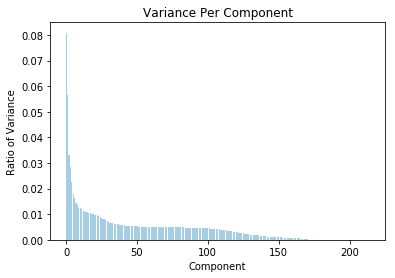

In [67]:
plt.bar(range(num_components), pca.explained_variance_ratio_)
plt.title('Variance Per Component')
plt.xlabel('Component')
plt.ylabel('Ratio of Variance')
plt.show()

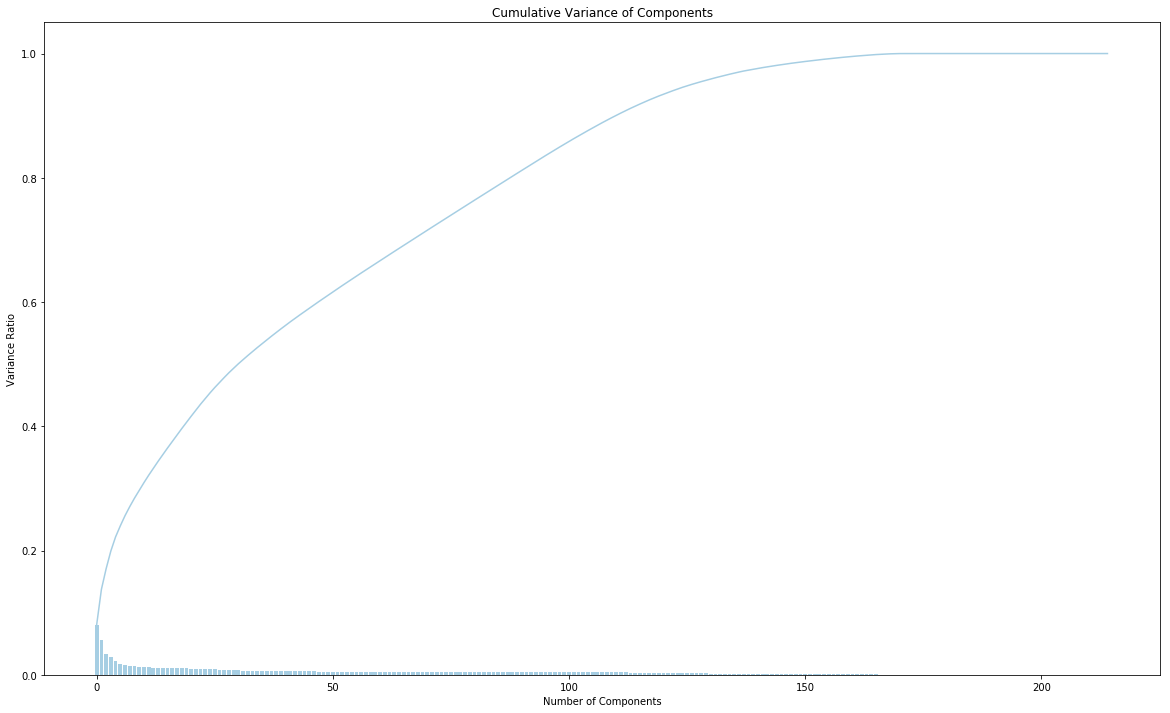

In [68]:
# Creating a skree plot
plt.figure(figsize=(20,12))
ax = plt.subplot(111)
cumvals = np.cumsum(pca.explained_variance_ratio_)
ax.bar(np.arange(num_components), pca.explained_variance_ratio_)
ax.plot(np.arange(num_components), cumvals)
plt.title('Cumulative Variance of Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')
plt.show()

In [69]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 100) # 100 is about 80%, not perfect but still a lot of variables!
azdias_clean_pca = pca.fit_transform(azdias_clean_ss)

__References:__ https://knowledge.udacity.com/questions/337494 I thought I had run the cell, turns out I made a change that I hadn't run, thus the error because I didn't fit the data right...

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

https://stackoverflow.com/questions/32238886/numpy-module-has-no-attribute-arrange I didn't realize it was arange, oops...

### Discussion 2.2: Perform Dimensionality Reduction
I retained 100 components, decreasing the component count by about half. 80% seemed a fair goal to aim for, and 100 met that requirement. Per the skree chart above, between 100 and 120 is about where the variance starts to taper off, which is another reason 80% is a good choice to aim for.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [70]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
df_pca_loadings = pd.DataFrame(pca.components_)
df_pca_loadings.head()

,0,1,2,3,4,5,6,7,8,9,...,205,206,207,208,209,210,211,212,213,214
0,-0.076945,0.010073,-0.178570,0.105840,-0.079929,0.045815,0.049279,0.135949,-0.101198,0.010115,...,0.034614,0.054393,0.055267,0.053870,0.015192,0.0,0.058984,-0.101198,-0.174859,-0.105214
1,0.218603,0.032322,0.091508,-0.227000,0.216596,-0.204901,-0.210047,0.084334,-0.004584,-0.040192,...,-0.007650,0.001392,0.005784,0.010905,0.034693,-0.0,-0.228045,-0.004584,-0.050210,0.011962
2,0.008879,-0.335451,0.126669,-0.045027,0.039622,-0.147443,-0.031434,-0.066215,0.093730,0.016888,...,-0.002950,0.011596,0.025592,0.011268,-0.001947,0.0,-0.036946,0.093730,-0.010764,-0.013326
3,-0.006658,0.110143,-0.015468,0.005822,-0.003717,-0.029624,0.023830,-0.004566,0.182718,-0.031560,...,0.016656,0.003006,0.006664,0.005879,0.002194,-0.0,0.024031,0.182718,0.008266,0.002475
4,0.045756,-0.051273,0.008084,-0.019624,0.036112,0.054507,-0.105339,0.026287,-0.240680,0.000277,...,0.052588,0.033236,0.015346,0.017147,-0.001199,-0.0,-0.033430,-0.240680,-0.138893,-0.068967


In [71]:
def weights(pca, i):
    weighted = pd.DataFrame(pca.components_, columns = azdias_clean.keys().tolist())
    return weighted.iloc[i].sort_values(ascending = False) # Most weighted will be at the top

In [72]:
weights(pca, 0)

LP_STATUS_GROB_1.0      0.184396
HH_EINKOMMEN_SCORE      0.175536
PLZ8_ANTG3              0.174450
PLZ8_ANTG4              0.169889
PLZ8_BAUMAX             0.166378
ORTSGR_KLS9             0.148327
EWDICHTE                0.146170
FINANZ_HAUSBAUER        0.135949
LP_STATUS_FEIN_1.0      0.125802
KBA05_ANTG4             0.124152
PLZ8_ANTG2              0.117180
ANZ_HAUSHALTE_AKTIV     0.111683
KBA05_BAUMAX            0.111028
KBA05_ANTG3             0.110764
ARBEIT                  0.108095
CAMEO_DEUG_2015_9       0.106702
FINANZ_SPARER           0.105840
LP_STATUS_FEIN_2.0      0.102053
FINANZTYP_1             0.100711
RELAT_AB                0.100371
LP_FAMILIE_FEIN_1.0     0.099242
LP_FAMILIE_GROB_1.0     0.099242
CAMEO_DEUG_2015_8       0.087276
SEMIO_PFLICHT           0.074724
ZABEOTYP_5              0.074410
SEMIO_REL               0.069946
REGIOTYP                0.067616
SEMIO_RAT               0.064687
GEBAEUDETYP_3.0         0.063345
AGER_TYP_-1             0.063125
          

In [73]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights(pca, 1)

ALTERSKATEGORIE_GROB     0.218603
FINANZ_VORSORGER         0.216596
ZABEOTYP_3               0.193459
SEMIO_ERL                0.173563
SEMIO_LUST               0.159761
RETOURTYP_BK_S           0.156346
W_KEIT_KIND_HH           0.128252
AGER_TYP_2               0.116438
CJT_GESAMTTYP_2.0        0.103436
FINANZTYP_5              0.096744
FINANZ_MINIMALIST        0.091508
AGER_TYP_1               0.090449
LP_STATUS_FEIN_1.0       0.090207
FINANZTYP_2              0.090023
FINANZ_HAUSBAUER         0.084334
SHOPPER_TYP_3            0.071338
SEMIO_KRIT               0.070783
CJT_GESAMTTYP_1.0        0.067674
NATIONALITAET_KZ_1       0.062706
LP_FAMILIE_GROB_1.0      0.062207
LP_FAMILIE_FEIN_1.0      0.062207
PLZ8_ANTG3               0.060929
EWDICHTE                 0.059407
FINANZTYP_6              0.058996
ORTSGR_KLS9              0.058704
PLZ8_ANTG4               0.057863
GFK_URLAUBERTYP_4.0      0.057163
PLZ8_BAUMAX              0.054261
WOHNDAUER_2008           0.054196
LP_STATUS_FEIN

In [74]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights(pca, 2)

SEMIO_VERT             0.313693
SEMIO_FAM              0.254986
SEMIO_SOZ              0.254334
SEMIO_KULT             0.244501
FINANZTYP_5            0.135281
FINANZ_MINIMALIST      0.126669
SHOPPER_TYP_0          0.125181
ZABEOTYP_1             0.121656
SEMIO_REL              0.119985
movement               0.093730
GREEN_AVANTGARDE       0.093730
SEMIO_MAT              0.083142
ORTSGR_KLS9            0.077546
EWDICHTE               0.077199
RETOURTYP_BK_S         0.075183
LP_STATUS_FEIN_10.0    0.067414
LP_STATUS_GROB_5.0     0.067414
PLZ8_BAUMAX            0.058035
PLZ8_ANTG4             0.056210
PLZ8_ANTG3             0.054768
W_KEIT_KIND_HH         0.050587
AGER_TYP_2             0.045904
ZABEOTYP_6             0.042589
LP_STATUS_GROB_3.0     0.042245
LP_STATUS_FEIN_3.0     0.041848
FINANZ_VORSORGER       0.039622
RELAT_AB               0.039292
SHOPPER_TYP_1          0.039067
PLZ8_ANTG2             0.038384
LP_STATUS_FEIN_1.0     0.037491
                         ...   
decade  

__References:__ https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components The first answer with terminology and parts is really helpful

### Discussion 2.3: Interpret Principal Components
Most weighted component is LP_STATUS_GROB_1.0, second is ALTERSKATEGORIE_GROB, third is SEMIO_VERT.

It makes sense that the social/economical status and age have high weights. These are things we see in our everyday lives having a strong impact on interactions between people, and between people and businesses. I'm not sure how the personality typology fits in here - the descriptions are somewhat vague, like "low affinity". What is it a low affinity for, the specific product? Mail adverts in general? The ALTERSKATEGORIE has a strong positive affinity with other age-related columns; the SEMIO columns seem to have a strong positive affinity with each other. Interestingly, it appears SEMIO has a negative correlation with ANREDE (gender) - does this suggest that one gender has a higher affinity for mail adverts than others?

Snips from Data_Dictionary.md for reference:

### 1.16. LP_STATUS_GROB
Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [75]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
scores = []
clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for k in clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    kresult = kmeans.fit(azdias_clean_pca)
    
    # compute the average within-cluster distances.
    #score = np.abs(kmeans.score(azdias_clean_ss))
    score = np.abs(kresult.score(azdias_clean_pca))
    scores.append(score)

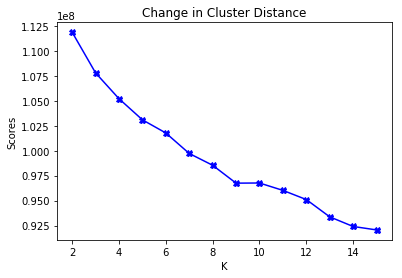

In [76]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, marker='X', color='blue')
plt.title('Change in Cluster Distance')
plt.xlabel('K')
plt.ylabel('Scores')
plt.show()

In [77]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
## I feel that about 8 clusters fits the data nicely per the graph above! The "elbow" isn't perfect, 
## but it is reasonable enough to fit most of the data.
kmeans = KMeans(n_clusters=8)
model = kmeans.fit(azdias_clean_pca)
cluster_pred = model.predict(azdias_clean_pca)

In [78]:
predictions = model.predict(azdias_clean_pca)
predictions

array([7, 4, 4, ..., 1, 5, 4], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population
By using k-means and then plotting the results, I determined that the best number of clusters for my dataset is 8. This is about where the data kind of flattens out, is around a score of 1, and is a fairly low number to allow for easier processing.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [106]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [107]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
## Clean dataset!
customers_clean = clean_data(customers)

The above function was successful, but there were some outstanding issues with the customers_clean dataset. The Ws were still present, as were some NAs (despite having both statements as part of the function). When I attempted to compare to the azdias data, there was a column count mismatch. I exported the column lists and compared, finding "GEBAEUETYP_5.0", perc_na, and TITEL_KZ_2.0 missing from customers_clean. customers_clean had two columns that azdias did not - LP_FAMILIE_FEIN_0.0 and LP_FAMILIE_GROB_0.0.

In [108]:
customers_clean = customers_clean.dropna()

In [109]:
# Adding zeros for all the cells in this column
customers_clean['GEBAEUDETYP_5.0'] = pd.Series(np.zeros(123205)) # Number of rows in dataset
customers_clean['perc_na'] = pd.Series(np.zeros(123205))
customers_clean['TITEL_KZ_2.0'] = pd.Series(np.zeros(123205))

In [110]:
# In a perfect, ideal world of data, our datasets would match here, even after the cleaning function. Alas.
customers_clean = customers_clean.drop(['LP_FAMILIE_FEIN_0.0','LP_FAMILIE_GROB_0.0'], axis=1)

In [111]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0

In [112]:
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d

In [113]:
customers = fix_columns(customers_clean, azdias_clean.columns.tolist())

set()


In [114]:
customers_clean = customers_clean.fillna(0)

In [115]:
cs = scaler.transform(customers_clean)

In [116]:
cs_pca = pca.transform(cs)

In [117]:
pred_cs = model.predict(cs_pca)

__References:__ https://stackoverflow.com/questions/45847006/valueerror-operands-could-not-be-broadcast-together-with-shapes-inverse-trans

Asking a question in the forum https://knowledge.udacity.com/questions/856173 referred me to this set of function definitions https://knowledge.udacity.com/questions/65620

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [124]:
azdias_clean_pca

array([[ 4.59478113, -4.0794219 , -2.8573329 , ...,  1.42051713,
        -0.39306192, -3.10252429],
       [-0.24791935, -0.84561912, -3.46762071, ..., -0.81660563,
        -1.35769029,  0.36771917],
       [-0.65880619, -0.03355104,  3.33687322, ..., -0.28048807,
        -0.08686802, -0.14547497],
       ..., 
       [ 6.20114717,  1.65372943,  0.83079518, ..., -0.1856901 ,
        -0.60161168, -0.52431279],
       [ 5.89044862, -4.6822747 ,  3.07309116, ..., -0.72814766,
        -0.9789174 , -0.28731082],
       [ 0.85597366,  2.18473466,  1.28586167, ...,  0.19324161,
        -0.57397733, -0.04674839]])

Text(0.5,0,'Cluster Number')

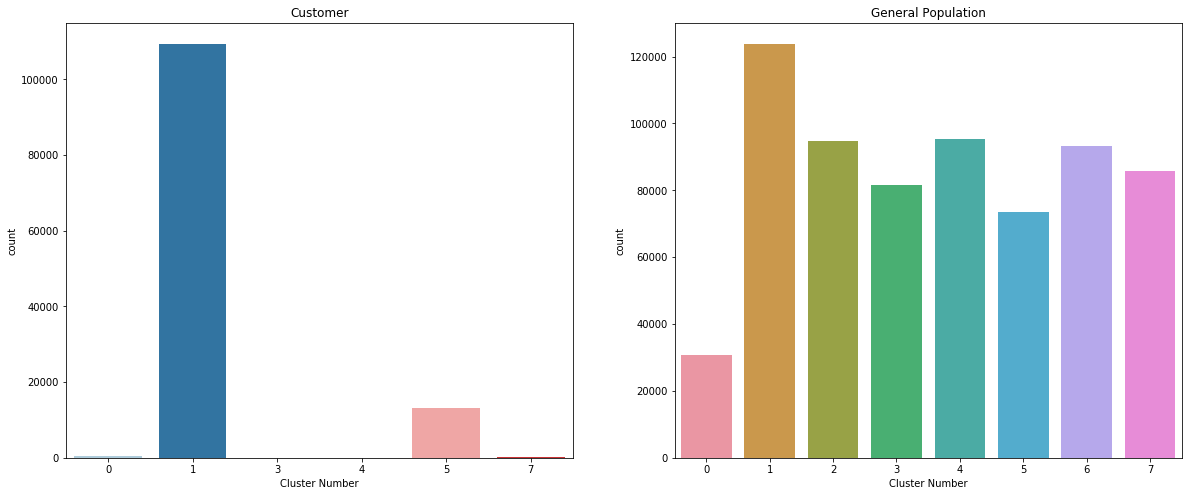

In [129]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(pred_cs, ax=ax1)
ax1.title.set_text('Customer')
ax1.set_xlabel('Cluster Number')
sns.countplot(predictions, ax=ax2)
ax2.title.set_text('General Population')
ax2.set_xlabel('Cluster Number')

In [140]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrep = model.cluster_centers_[5]

In [141]:
overrep = pca.inverse_transform(overrep)

In [142]:
overrep = scaler.inverse_transform(overrep)

In [143]:
# Setting the index to the clean dataset's column names, otherwise it comes through as just numbers
overrep = pd.Series(data = overrep, index=azdias_clean.columns)

In [149]:
overrep

ALTERSKATEGORIE_GROB      1.948331
ANREDE_KZ                 0.958408
FINANZ_MINIMALIST         2.066725
FINANZ_SPARER             4.188125
FINANZ_VORSORGER          2.185229
FINANZ_ANLEGER            3.392176
FINANZ_UNAUFFAELLIGER     3.610945
FINANZ_HAUSBAUER          3.500256
GREEN_AVANTGARDE          0.112101
HEALTH_TYP                2.387790
LP_LEBENSPHASE_FEIN       9.430173
LP_LEBENSPHASE_GROB       3.150150
RETOURTYP_BK_S            2.857623
SEMIO_SOZ                 6.484320
SEMIO_FAM                 6.639919
SEMIO_REL                 6.052671
SEMIO_MAT                 5.167193
SEMIO_VERT                6.042134
SEMIO_LUST                3.089104
SEMIO_ERL                 2.339494
SEMIO_KULT                6.781512
SEMIO_RAT                 4.029767
SEMIO_KRIT                2.915990
SEMIO_DOM                 2.944144
SEMIO_KAEM                2.427201
SEMIO_PFLICHT             5.498640
SEMIO_TRADV               4.808165
SOHO_KZ                   0.012796
ANZ_PERSONEN        

In [150]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrep = model.cluster_centers_[7]
underrep = pca.inverse_transform(underrep)
underrep = scaler.inverse_transform(underrep)
underrep = pd.Series(data = underrep, index=azdias_clean.columns)

In [151]:
underrep

ALTERSKATEGORIE_GROB      1.762338
ANREDE_KZ                 2.009414
FINANZ_MINIMALIST         1.176900
FINANZ_SPARER             4.363423
FINANZ_VORSORGER          2.177861
FINANZ_ANLEGER            4.278848
FINANZ_UNAUFFAELLIGER     3.739982
FINANZ_HAUSBAUER          4.217864
GREEN_AVANTGARDE          0.051628
HEALTH_TYP                2.031145
LP_LEBENSPHASE_FEIN      10.270134
LP_LEBENSPHASE_GROB       3.419776
RETOURTYP_BK_S            2.326185
SEMIO_SOZ                 3.154610
SEMIO_FAM                 3.743985
SEMIO_REL                 5.086594
SEMIO_MAT                 4.647081
SEMIO_VERT                2.262095
SEMIO_LUST                2.963021
SEMIO_ERL                 4.367362
SEMIO_KULT                3.976019
SEMIO_RAT                 6.004021
SEMIO_KRIT                5.493110
SEMIO_DOM                 6.208666
SEMIO_KAEM                6.116901
SEMIO_PFLICHT             5.959952
SEMIO_TRADV               5.508581
SOHO_KZ                   0.003661
ANZ_PERSONEN        

### Discussion 3.3: Compare Customer Data to Demographics Data
My results show that none of the clusters of customer data are really overrepresented when compared to the general population. Cluster 1 is the highest in customer data, but it's also quite high in the general set. For overrepresentation, I went with cluster 5 as it is significantly higher than the other clusers (except 1) in the customer set.

Cluster 5 shows that most members of this cluster were born in the 80s.

Cluster 7 is significantly underrepresented when compared to the general dataset. Both the decade and "LP_LEBENSPHASE_FEIN" columns show a high impact on members of this cluster - again, most of cluster 7 was born in the 80s, and many of this cluster are wealthy single homeowners.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.